In [1]:
# 푸리에 변환 및 파워 스펙트럼 계산(fourier_transform_and_power_spectrum) : MFCC에서는 scipy.fftpack의 fft 함수를 사용하여 푸리에 변환을 수행 / MFCC2에서는 numpy의 fft.rfft 함수를 사용. 이 두 함수는 동일한 연산을 수행하지만, numpy의 rfft 함수는 실수 입력에 대해 효율적으로 작동
# 필터 뱅크 계산(filter_bank): MFCC2에서는 mel scale에서 동일하게 간격을 둔 포인트를 사용하여 hz_points를 계산 / MFCC에서는 min_freq와 max_freq를 사용하여 mel_points를 계산.
# 두 차이가 결정적 차이점

In [ ]:
#MFCC에서 적용했던 방법과 MFCCretry에서 적용했던 방법의 차이점
# Filter bank
# 1. 입력 파라미터 :
# MFCC : 푸리에 변환된 주파수 스펙트럼인 'magnitude_spectrum'을 입력으로 받음.
# retry : 파워 스펙트럼인 'power_spectrum'을 입력으로 받음. 파워 스펙트럼은 주파수 스펙트럼의 각 성분을 제곱한 것, 신호의 에너지를 나타냄
# magitude_spectrum을 입력으로 사용했을 때 : 주파수 도메인에서 각 필터의 평균 진폭 get
# pow_spectrum을 입력으로 사용했을 때 : 주파수 도메인에서 각 필터의 평균 에너지 get
# MFCC를 적용한 결과는 일반적으로 에너지 관련 정보를 포함
# MFCC : 원래의 시간 영역에서의 신호를 주파수 영역으로 변환한 후, 그 주파수 영역의 신호를 Mel 스케일로 변환하고, 그 결과에 이산 코사인 변환(DCT)을 적용하는 과정을 거침 
# 이 과정에서 파워 스펙트럼(에너지)을 기반으로 작업을 수행하며, 이는 각 주파수 구성 요소의 에너지를 나타냄
# 따라서 에너지 관련 정보를 나타내는 MFCC <- pow_spectrum을 적용하는 것이 타당함.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack as fft
from scipy.signal import hamming
from scipy.fftpack import dct
import librosa

# 첫 번째 샘플 signal[0]을 가져온 후, 이어지는 각 샘플에 대해 이전 샘플을 곱한 값(계수)을 뺌
# 사전 강조 : 음성 신호에서 고주파 성분의 에너지를 증가, 저주파 성분의 에너지를 감소시키는 과정 -> MFCC랑 반대인데..? 왜 이 과정이 필요할까 
# 이 과정을 통해 음성 신호의 스펙트럼이 좀 더 평탄해지고, 이후의 신호 처리 과정이 더 간단해진다고 함.
def pre_emphasis(signal, coefficient=0.95):
    return np.append(signal[0], signal[1:] - coefficient * signal[:-1])

# 음성 신호를 일정한 길이의 프레임으로 분할하는 과정 
# 일반적으로 스펙트럼 분석을 위해 음성 신호를 짧은 시간 단위로 나누는데, 이 때 각 단위를 프레임이라고 함
# 이 함수에서는 프레임의 길이와 스트라이드를 지정하고, 이에 따라 음성 신호를 프레임으로 나눔
def framing(signal, sample_rate, frame_size=0.025, frame_stride=0.01):

    # 오디오 데이터는 일반적으로 샘플 단위로 표현되며, 샘플 단위는 디지털 오디오의 기본적인 단위임
    # 프레임의 크기와 간격을 샘플 단위로 변환함으로써, 이후의 오디오 데이터 처리 과정에서 프레임 단위로 데이터를 쉽게 분할하고 분석 가능
    frame_length = int(round(frame_size * sample_rate)) #프레임의 크기(frame_size)를 초 단위에서 샘플 단위로 변환
    frame_step = int(round(frame_stride * sample_rate)) #프레임 간의 간격(frame_stride)을 초 단위에서 샘플 단위로 변환

    # 신호의 총 길이에서 프레임 길이를 뺀 후, 프레임 간의 간격으로 나누어 프레임의 총 수를 계산
    # np.ceil 함수를 사용하여 올림 처리
    num_frames = int(np.ceil(float(np.abs(len(signal) - frame_length)) / frame_step))

    # '패딩' : 일반적으로 데이터를 특정 길이에 맞추기 위해 추가하는 과정 
    # 원본 데이터의 크기가 고정 크기의 요구사항을 충족시키지 못하는 경우, 추가적인 데이터(일반적으로 0 또는 특정 값)를 덧붙여 원하는 크기를 만드는 것입니다.
    # 패딩 과정은 신호의 길이가 프레임 길이보다 짧거나, 프레임 단위로 정확하게 나누어 떨어지지 않을 경우에 필요
    # 신호의 길이가 프레임 길이보다 짧은 경우 : 데이터를 손실 없이 처리하기 위해 0으로 패딩
    # 신호의 길이가 프레임 단위로 정확하게 나누어 떨어지지 않는 경우 : 마지막 프레임이 다른 프레임보다 짧아질 수 있는데, 이 경우 모든 프레임이 동일한 길이를 갖도록 마지막 프레임을 0으로 패딩
    # 이렇게 패딩된 신호는 이후의 데이터 처리 과정에서 일관성 유지 가능
    
    # 패딩할 신호의 총 길이를 계산
    pad_signal_length = num_frames * frame_step + frame_length
    # 패딩할 신호의 길이에서 실제 신호의 길이를 뺀 크기 만큼의 0으로 이루어진 배열을 생성
    z = np.zeros((pad_signal_length - len(signal)))
    
    # np.append : 1차원 배열 병합
    # 실제 신호에 0으로 이루어진 배열을 추가하여 패딩 처리
    pad_signal = np.append(signal, z)
    
    # 각 프레임의 시작 인덱스를 계산. np.tile 함수를 사용하여 프레임 길이와 프레임 간의 간격에 해당하는 배열을 생성
    # 이 두 배열을 더하여 각 프레임이 시작되는 인덱스를 계산
    indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
    
    # 계산된 인덱스를 사용하여 패딩된 신호에서 각 프레임을 추출
    frames = pad_signal[indices.astype(np.int32, copy=False)]
    
    return frames

def windowing(frames):
    #윈도우 함수로 해밍 윈도우를 사용. 
    # 해밍 윈도우 : 오디오 신호 처리에 사용되는 윈도우 함수 중 하나, 프레임의 양 끝을 부드럽게 만들어 주어 신호 분석의 정확성을 높이는 역할
    frames *= hamming(frames.shape[1]) # 해밍 윈도우 함수를 이용하여 프레임 길이에 해당하는 윈도우를 생성. 이 윈도우를 원래 프레임에 곱함으로써 해밍 윈도우를 적용
    # 위 과정을 통해 프레임의 시작과 끝에서 발생하는 신호의 급격한 변화를 완화 -> Fourier Transform을 적용할 때 유용
    return frames

def fourier_transform_and_power_spectrum(frames, NFFT):
    # 오디오 프레임을 입력으로 받아, Fourier 변환을 수행한 후, 그 결과의 절대값을 취하여 주파수 영역에서의 신호의 크기를 get
    abs_spectrum = np.absolute(np.fft.rfft(frames, NFFT)) # windowing 함수를 통해 처리된 프레임들은 실수값으로 이루어져 있음 -> numpy의 rfft 함수는 실수 입력에 대해 효율적으로 작동
    pow_spectrum = ((1.0 / NFFT) * ((abs_spectrum) ** 2)) # abs_spectrum 값들을 통해 파워 스펙트럼을 계산
    # abs_spectrum은 주파수별 신호의 크기를 나타내는 값, pow_spectrum은 주파수별 신호의 에너지를 나타내는 값
    return pow_spectrum # 파워 스펙트럼을 나타내는 1차원의 실수 배열

def filter_bank(power_spectrum, sample_rate, NFFT, num_filters=40, min_freq=133.33, max_freq=None):

    num_filter = 40
    low_freq_mel = 0
    high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700)) # sample_rate의 절반까지의 주파수 범위를 Mel 스케일로 변환
    mel_points = np.linspace(low_freq_mel, high_freq_mel, num_filter + 2) # 이 범위를 nfilt + 2개의 동일한 간격으로 나눔
    hz_points = (700 * (10**(mel_points / 2595) - 1)) # Mel 스케일의 값들을 다시 Hz 스케일로 변환

    bin = np.floor((NFFT + 1) * hz_points / sample_rate) #각 Hz 값에 해당하는 FFT bin 번호를 계산
    fbank = np.zeros((num_filters,int(NFFT/2+1)))
    for m in range(1, num_filter + 1): # 각 필터에 대해, 해당 필터의 중심 주파수를 기준으로 왼쪽과 오른쪽에서 삼각형 형태의 필터를 생성
        f_m_minus = int(bin[m - 1])   # left
        f_m = int(bin[m])             # center
        f_m_plus = int(bin[m + 1])    # right

        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
    # 파워 스펙트럼에 이 필터 뱅크를 적용하고, 로그 스케일로 변환하여 반환
    filter_banks = np.dot(power_spectrum , fbank.T)
    filter_banks = np.where(filter_banks == 0,np.finfo(float).eps ,filter_banks)
    filter_banks = 20 * np.log10(filter_banks) # dB

    return filter_banks
    
def apply_dct(filter_banks, num_ceps=12): # filter_banks : 필터 뱅크, num_ceps : 계수의 개수 지정
    mfccs = dct(filter_banks, type=2, axis=-1, norm='ortho')[:,:num_ceps] # dct 함수를 사용해 filter_banks에 이산 코사인 변환을 적용
    # type=2 : DCT-II 타입을 사용하겠다는 의미 -> 이는 DCT의 가장 일반적인 형태 
    # axis=-1 : 변환을 적용할 축을 지정 -> -1은 마지막 차원을 의미
    # norm='ortho' : 직교(orthonormal) 정규화를 적용 
    return mfccs

C:\Users\dasom\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


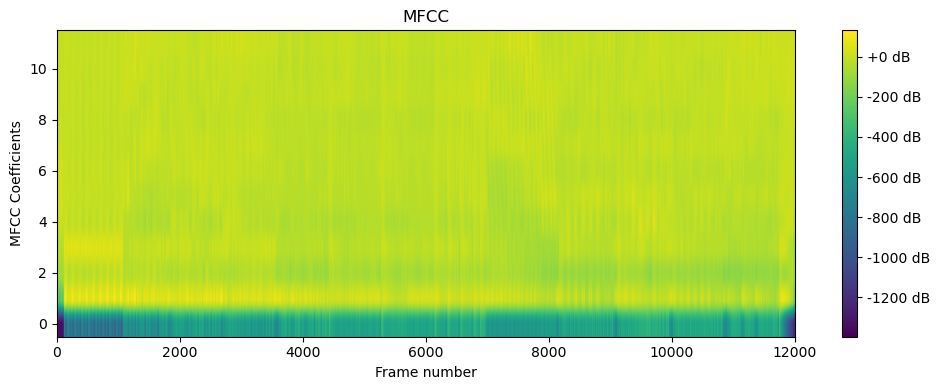

In [3]:
# Load an audio file
filename = librosa.example('nutcracker')
signal, sample_rate = librosa.load(filename, sr=None)

# Pre-emphasis
pre_emphasized_signal = pre_emphasis(signal)

# Framing
frames = framing(pre_emphasized_signal, sample_rate)

# Windowing
windowed_frames = windowing(frames)

# Fourier Transform and Power Spectrum
NFFT = 512  # You can choose the value that fits your needs.
power_spectrum = fourier_transform_and_power_spectrum(windowed_frames, NFFT)

# Filter Banks
filter_banks_result = filter_bank(power_spectrum,sample_rate,NFFT,num_filters=40,min_freq=133.33, max_freq=None)

# Apply DCT to get MFCCs
mfccs_result = apply_dct(filter_banks_result)

# Plotting the MFCC
plt.figure(figsize=(10, 4))
plt.imshow(mfccs_result.T, origin='lower', aspect='auto', cmap='viridis')
plt.title('MFCC')
plt.ylabel('MFCC Coefficients')
plt.xlabel('Frame number')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

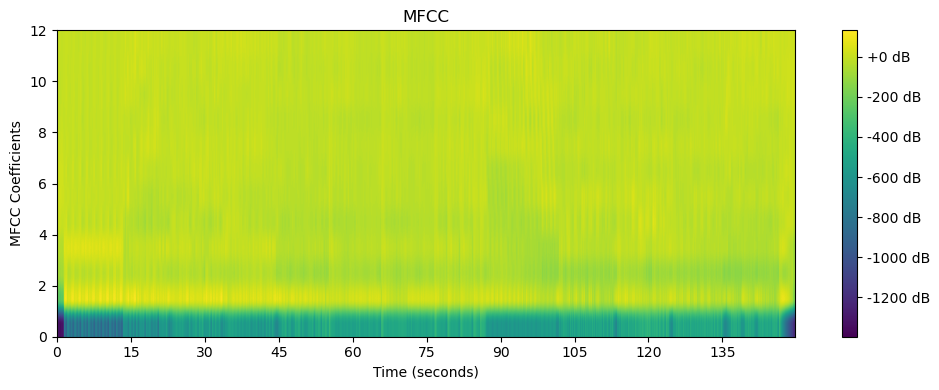

In [4]:
def get_frame_times(frames, sample_rate):

    frame_length = len(frames[0])
    hop_length = frame_length // 2  # 일반적인 hop length value
    
    num_frames = len(frames)
    
    frame_times = librosa.frames_to_time(range(num_frames), sr=sample_rate, hop_length=hop_length, n_fft=frame_length)
    
    return frame_times

# Load an audio file
filename = librosa.example('nutcracker')
signal, sample_rate = librosa.load(filename, sr=None)

# Pre-emphasis
pre_emphasized_signal = pre_emphasis(signal)

# Framing
frames = framing(pre_emphasized_signal, sample_rate)

# Windowing
windowed_frames = windowing(frames)

# Fourier Transform and Power Spectrum
NFFT = 512  # 변환가능한 매개변수
power_spectrum = fourier_transform_and_power_spectrum(windowed_frames, NFFT)

# Filter Banks
filter_banks_result = filter_bank(power_spectrum,sample_rate,NFFT,num_filters=40,min_freq=133.33, max_freq=None)

# Apply DCT to get MFCCs
mfccs_result = apply_dct(filter_banks_result)

# Get frame times
frame_times = get_frame_times(frames, sample_rate)

# Plotting the MFCC
plt.figure(figsize=(10, 4))
plt.imshow(mfccs_result.T, origin='lower', aspect='auto', cmap='viridis', extent=[frame_times.min(), frame_times.max(), 0, mfccs_result.shape[1]])
plt.title('MFCC')
plt.ylabel('MFCC Coefficients')
plt.xlabel('Time (seconds)')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

# Set xticks to 15 seconds interval
max_time = frame_times.max()
plt.xticks(np.arange(0, max_time, 15))
plt.show()

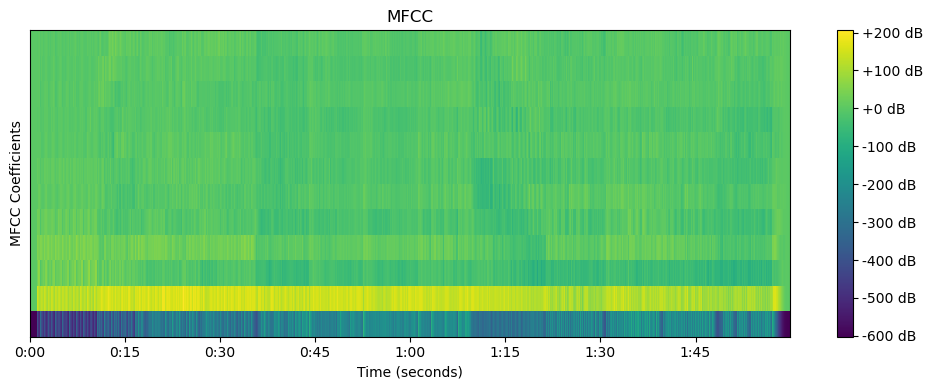

In [5]:
import matplotlib.pyplot as plt
import librosa
import librosa.display

# Load an audio file
filename = librosa.example('nutcracker')
signal, sample_rate = librosa.load(filename, sr=None)

# Calculate MFCCs
mfccs = librosa.feature.mfcc(signal, sr=sample_rate, n_mfcc=12) # n_mfcc와 동일한 역할을 하는 매개변수는 apply_dct 함수의 num_ceps

# Plotting the MFCC
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis='time', cmap='viridis')
plt.title('MFCC')
plt.ylabel('MFCC Coefficients')
plt.xlabel('Time (seconds)')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

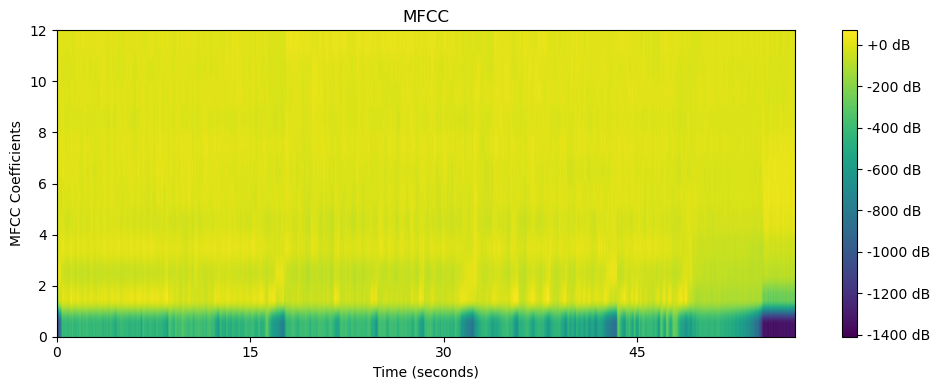

In [6]:
# Load an audio file
filename = librosa.example('brahms')
signal, sample_rate = librosa.load(filename, sr=None)

# Pre-emphasis
pre_emphasized_signal = pre_emphasis(signal)

# Framing
frames = framing(pre_emphasized_signal, sample_rate)

# Windowing
windowed_frames = windowing(frames)

# Fourier Transform and Power Spectrum
NFFT = 512  # 변환가능한 매개변수
power_spectrum = fourier_transform_and_power_spectrum(windowed_frames, NFFT)

# Filter Banks
filter_banks_result = filter_bank(power_spectrum,sample_rate,NFFT,num_filters=40,min_freq=133.33, max_freq=None)

# Apply DCT to get MFCCs
mfccs_result = apply_dct(filter_banks_result)

# Get frame times
frame_times = get_frame_times(frames, sample_rate)

# Plotting the MFCC
plt.figure(figsize=(10, 4))
plt.imshow(mfccs_result.T, origin='lower', aspect='auto', cmap='viridis', extent=[frame_times.min(), frame_times.max(), 0, mfccs_result.shape[1]])
plt.title('MFCC')
plt.ylabel('MFCC Coefficients')
plt.xlabel('Time (seconds)')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

# Set xticks to 15 seconds interval
max_time = frame_times.max()
plt.xticks(np.arange(0, max_time, 15))
plt.show()

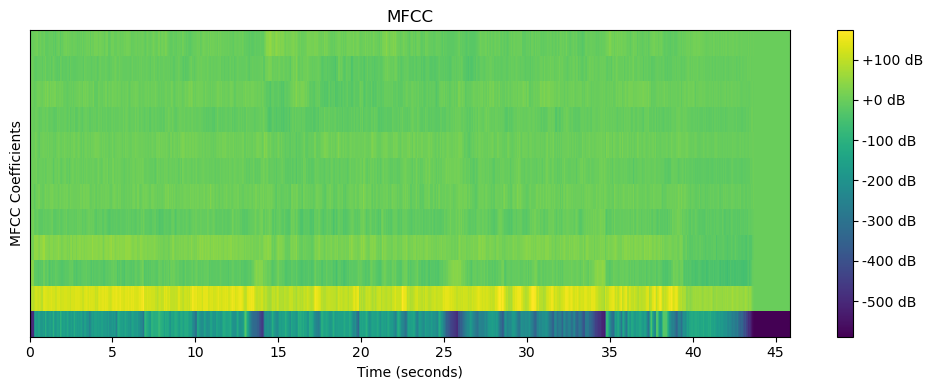

In [7]:
import matplotlib.pyplot as plt
import librosa
import librosa.display

# Load an audio file
filename = librosa.example('brahms')
signal, sample_rate = librosa.load(filename, sr=None)

# Calculate MFCCs
mfccs = librosa.feature.mfcc(signal, sr=sample_rate, n_mfcc=12)

# Plotting the MFCC
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis='time', cmap='viridis')
plt.title('MFCC')
plt.ylabel('MFCC Coefficients')
plt.xlabel('Time (seconds)')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

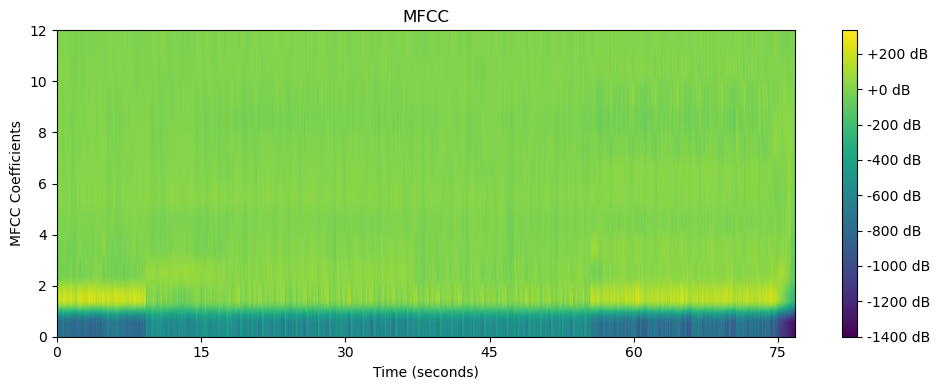

In [8]:
# Load an audio file
filename = librosa.example('vibeace')
signal, sample_rate = librosa.load(filename, sr=None)

# Pre-emphasis
pre_emphasized_signal = pre_emphasis(signal)

# Framing
frames = framing(pre_emphasized_signal, sample_rate)

# Windowing
windowed_frames = windowing(frames)

# Fourier Transform and Power Spectrum
NFFT = 512  # 변환가능한 매개변수
power_spectrum = fourier_transform_and_power_spectrum(windowed_frames, NFFT)

# Filter Banks
filter_banks_result = filter_bank(power_spectrum,sample_rate,NFFT,num_filters=40,min_freq=133.33, max_freq=None)

# Apply DCT to get MFCCs
mfccs_result = apply_dct(filter_banks_result)

# Get frame times
frame_times = get_frame_times(frames, sample_rate)

# Plotting the MFCC
plt.figure(figsize=(10, 4))
plt.imshow(mfccs_result.T, origin='lower', aspect='auto', cmap='viridis', extent=[frame_times.min(), frame_times.max(), 0, mfccs_result.shape[1]])
plt.title('MFCC')
plt.ylabel('MFCC Coefficients')
plt.xlabel('Time (seconds)')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

# Set xticks to 15 seconds interval
max_time = frame_times.max()
plt.xticks(np.arange(0, max_time, 15))
plt.show()

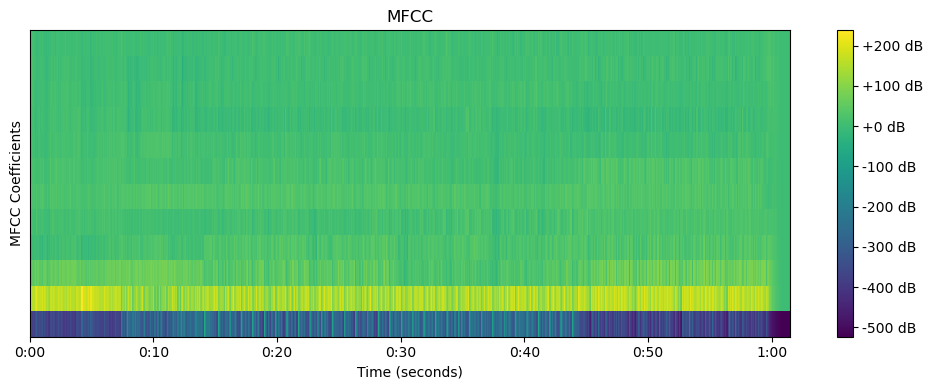

In [9]:
import matplotlib.pyplot as plt
import librosa
import librosa.display

# Load an audio file
filename = librosa.example('vibeace')
signal, sample_rate = librosa.load(filename, sr=None)

# Calculate MFCCs
mfccs = librosa.feature.mfcc(signal, sr=sample_rate, n_mfcc=12)

# Plotting the MFCC
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis='time', cmap='viridis')
plt.title('MFCC')
plt.ylabel('MFCC Coefficients')
plt.xlabel('Time (seconds)')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()